In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-07 15:31:02.103274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 15:31:02.561219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_image_path = glob.glob('/home/jhr/Documents/data/dc_2000/train/*/*.jpg')
train_image_label = [int(p.split('/')[-1].split('.')[0] == 'cat')
                     for p in train_image_path]
train_image_label[:5],len(train_image_path)

([1, 1, 1, 1, 1], 2000)

In [3]:
train_image_path_test = glob.glob('/home/jhr/Documents/data/dc_2000/test/*/*.jpg')
train_image_label_test  = [int(p.split('/')[-1].split('.')[0] == 'cat')
                     for p in train_image_path_test ]

train_image_label_test [:5],len(train_image_path_test)

([1, 1, 1, 1, 1], 1000)

In [4]:
#图片增强
def load_precess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    # image = tf.image.random_crop(image, [256, 256, 3])  # 随机裁剪
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # image = tf.image.random_brightness(image, 0.5)
    # image = tf.image.random_hue(image,0.5)
    # image = tf.image.random_contrast(image, 0, 1)
    image = tf.cast(image, tf.float32)
    image = image/255  # 归一化
    label = tf.reshape(label, [1])
    return image, label

def load_precess_image_test(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255  # 归一化
    label = tf.reshape(label, [1])
    return image, label

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(
    (train_image_path, train_image_label))
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = dataset.map(load_precess_image,
                      num_parallel_calls=AUTOTUNE)

In [6]:
dataset_test = tf.data.Dataset.from_tensor_slices(
    (train_image_path_test, train_image_label_test))
dataset_test = dataset_test.map(load_precess_image_test,
                      num_parallel_calls=AUTOTUNE)

In [7]:
step=32
dataset=dataset.shuffle(2000).repeat().batch(step)
dataset_test=dataset_test.batch(step)

In [8]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

In [9]:
dataset_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

通过trainable参数，冻结vgg16模型的卷积层参数，只对我们后续添加的分类层进行训练，
从而提高训练速度，提高训练精度

In [10]:
covn_base = tf.keras.applications.xception.Xception(include_top=False,
                                           weights='imagenet',
                                           input_shape=(256, 256, 3),
                                           pooling='avg')

covn_base.trainable = False  # 设定不可训练

In [11]:
# covn_base.summary()

In [12]:
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21911081 (83.58 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['acc'])

In [15]:
initial_epochs=5

In [16]:
# import os
# import datetime
# log_dir = os.path.join(
#     'logs', datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S"))

# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=log_dir, histogram_freq=1)

# # 创建文件编写器
# file_writer = tf.summary.create_file_writer(log_dir+'/lr')
# file_writer.set_as_default()

In [17]:
history = model.fit_generator(dataset,
                              steps_per_epoch=2000//step,
                              epochs=initial_epochs,
                              validation_data=dataset_test,
                              validation_steps=1000//step,
                              # callbacks=[tensorboard_callback]
             )

Epoch 1/5


/tmp/ipykernel_72740/870880192.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataset,
2023-08-07 15:31:22.836740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2023-08-07 15:31:23.627667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-07 15:31:23.874646: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1cf78d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-07 15:31:23.874665: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-08-07 15:31:23.881833: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproduce

62/62 [==============================] - 13s 153ms/step - loss: 0.1810 - acc: 0.9284 - val_loss: 0.0445 - val_acc: 0.9869
Epoch 2/5
62/62 [==============================] - 9s 144ms/step - loss: 0.1162 - acc: 0.9546 - val_loss: 0.0307 - val_acc: 0.9909
Epoch 3/5
62/62 [==============================] - 9s 145ms/step - loss: 0.1069 - acc: 0.9577 - val_loss: 0.0369 - val_acc: 0.9859
Epoch 4/5
62/62 [==============================] - 9s 145ms/step - loss: 0.0628 - acc: 0.9718 - val_loss: 0.0259 - val_acc: 0.9940
Epoch 5/5
62/62 [==============================] - 9s 146ms/step - loss: 0.0634 - acc: 0.9743 - val_loss: 0.0289 - val_acc: 0.9919


In [18]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

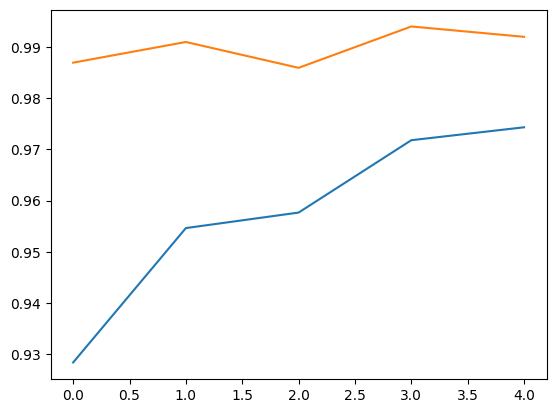

In [19]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')

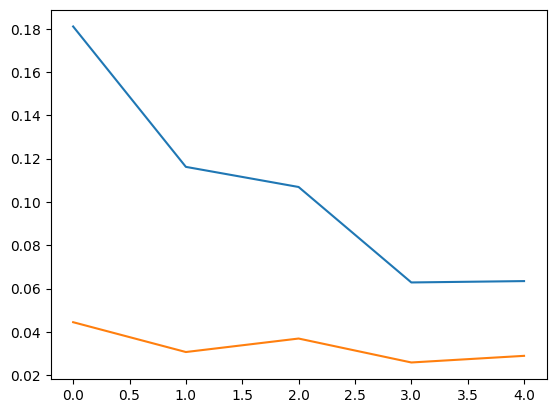

In [20]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')

## 微调模型

In [21]:
covn_base.trainable=True

In [22]:
len(covn_base.layers)

133

In [23]:
#封锁分类层
fine_tune_at = -33
for layers in covn_base.layers[:fine_tune_at]:
  layers.trainable=False

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0005/10),
              metrics=['acc'])

In [25]:
fine_tune_epochs=10#再次训练次数
total_epochs=initial_epochs+fine_tune_epochs

history = model.fit_generator(dataset,
                              steps_per_epoch=2000//step,
                              epochs=total_epochs,
                              initial_epoch=initial_epochs,
                              validation_data=dataset_test,
                              validation_steps=1000//step,
                              # callbacks=[tensorboard_callback]
             )

Epoch 6/15


/tmp/ipykernel_72740/675788415.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataset,


62/62 [==============================] - 20s 188ms/step - loss: 0.1929 - acc: 0.9340 - val_loss: 0.1370 - val_acc: 0.9758
Epoch 7/15
62/62 [==============================] - 11s 183ms/step - loss: 0.0814 - acc: 0.9728 - val_loss: 0.2692 - val_acc: 0.9647
Epoch 8/15
62/62 [==============================] - 11s 183ms/step - loss: 0.0593 - acc: 0.9798 - val_loss: 0.1476 - val_acc: 0.9819
Epoch 9/15
62/62 [==============================] - 11s 183ms/step - loss: 0.0500 - acc: 0.9844 - val_loss: 0.2099 - val_acc: 0.9768
Epoch 10/15
62/62 [==============================] - 11s 184ms/step - loss: 0.0526 - acc: 0.9758 - val_loss: 0.2824 - val_acc: 0.9657
Epoch 11/15
62/62 [==============================] - 11s 184ms/step - loss: 0.0229 - acc: 0.9934 - val_loss: 0.1475 - val_acc: 0.9607
Epoch 12/15
62/62 [==============================] - 11s 183ms/step - loss: 0.0405 - acc: 0.9879 - val_loss: 0.0698 - val_acc: 0.9788
Epoch 13/15
62/62 [==============================] - 11s 183ms/step - loss: 0

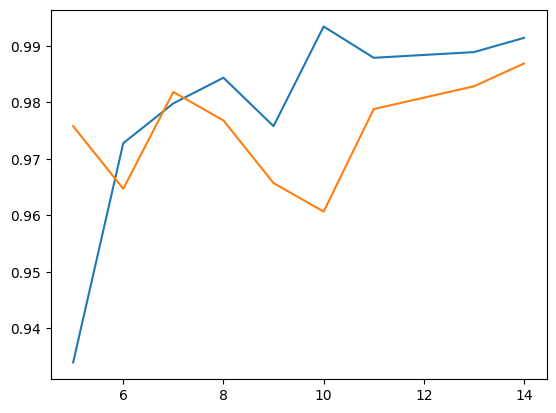

In [26]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')

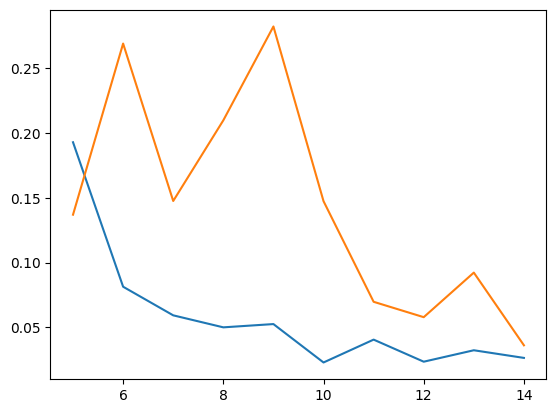

In [27]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')